In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import re

In [2]:
output_path = "/data/bruce/progress_report/lihc/0531/"

### import candidate gene profile

In [3]:
candidate_df = pd.read_csv('/data/bruce/progress_report/lihc/0531/candidate_gene.txt',sep='\t')

path = '/home/bruce1996/data/LIHC_anomaly_detection/'
lihc_df = pd.read_csv(path + 'lihc_coding_gene_exp_profile.txt',sep = '\t',index_col = 0)
###standardization 
lihc_hbv_array = lihc_df.T.to_numpy()
scaler = StandardScaler().fit(lihc_hbv_array)
lihc_df_stand = scaler.transform(lihc_hbv_array)

sample_df = pd.DataFrame({'Sample' : [x.split('.')[0] for x in lihc_df.columns],'Label' : ['Tumor'] * lihc_df.shape[1]})
idx = [bool(re.search('\.',x)) for x in lihc_df.columns]
sample_df.loc[idx,"Label"] = 'Normal'

In [4]:
clinical_info_file = 'nationwidechildrens.org_clinical_patient_lihc.txt'
clinical_info = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/' + clinical_info_file,sep='\t')
clinical_info = clinical_info.drop([0,1],axis=0)
idx = [x.split('-')[-1] for x in clinical_info['bcr_patient_barcode']]
clinical_info.index = idx

idx = [bool(re.search('Hepatitis B Surface Antigen' ,x )) for x in clinical_info.loc[:,'viral_hepatitis_serology'].values]
#idx = [bool(re.search('Hepatitis B | HBV' ,x )) for x in clinical_info.loc[:,'viral_hepatitis_serology'].values]

hbv_positive = clinical_info.loc[idx,'viral_hepatitis_serology'].index
tmp = []
for x in sample_df['Sample'] :
    if x in hbv_positive :
        tmp.append('Positive')
    else :
        tmp.append('Negative')
sample_df['HBV'] = tmp
hbv_idx = sample_df[sample_df['HBV'] == 'Positive']

### Differential expression analysis
1. Deseq2 <br>
2. volcano plot <br>

In [5]:
###load deseq2 result 
deseq2_df = pd.read_csv(path + 'deseq2_result_of_candidate_gene.txt',sep = '\t')

In [6]:
deseq2_df['Status'] = np.where( (abs(deseq2_df['log2FoldChange'])>2) & (deseq2_df['padj'] < 0.05), 'Significant', 'No significant')

In [13]:
from math import log10
deseq2_df['log-p-value'] = [abs(log10(x)) for x in deseq2_df['padj'].values]
deseq2_df['ID'] = deseq2_df.index

In [17]:
candidate_df

,ID,Label
ENSG00000175063,ENSG00000175063,HBV-associated
ENSG00000164611,ENSG00000164611,HBV-associated
ENSG00000263513,ENSG00000263513,Candidate gene
ENSG00000168078,ENSG00000168078,HBV-associated
ENSG00000080986,ENSG00000080986,Candidate gene
...,...,...
ENSG00000122223,ENSG00000122223,Candidate gene
ENSG00000155659,ENSG00000155659,HBV-associated
ENSG00000174837,ENSG00000174837,HBV-associated
ENSG00000145287,ENSG00000145287,HBV-associated


In [18]:
candidate_df.index = candidate_df['ID'].values
candidate_df = candidate_df.loc[deseq2_df['ID'].values,:]
deseq2_df['Gene label'] = candidate_df['Label']

In [22]:
output_path

'/data/bruce/progress_report/lihc/0531/'

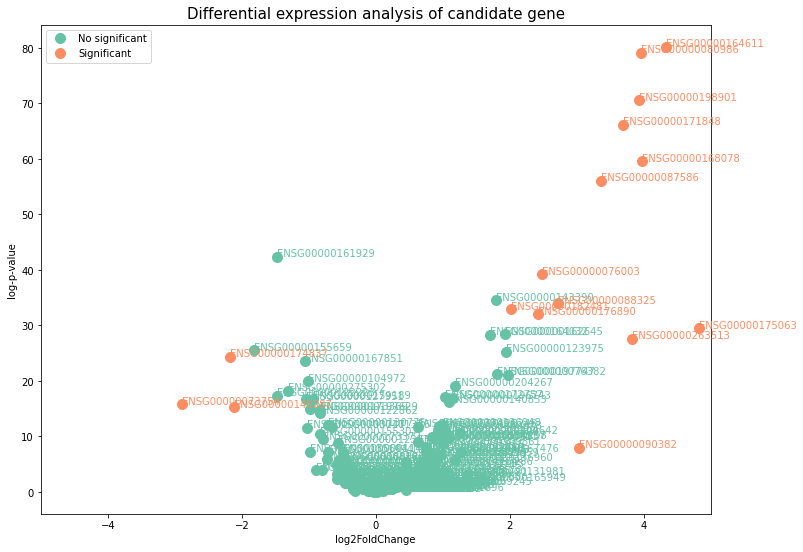

In [21]:
import matplotlib
plot_df =deseq2_df
col_x='log2FoldChange'
col_y='log-p-value'
col_group='Status'
col_label='ID'
output_path = output_path
name = "deseq2-volcano-plot.png"
title = 'Differential expression analysis of candidate gene'

x_col = col_x
y_col = col_y
hue_col = col_group
label_col = col_label
palette = 'Set2'
size = 10

fig, ax = plt.subplots(figsize = (12,9))
colors = matplotlib.cm.get_cmap(palette)(range(len(plot_df[hue_col].unique())))
for (g,temp),c in zip(plot_df.groupby(col_group),colors):
    ax.plot(temp[x_col], temp[y_col], 'o', color=c, ms=size, label=g)
    for i,row in temp.iterrows():
        ax.annotate(row[label_col], xy=(row[x_col],row[y_col]), color=c)

#plot_lim = max(max(df[col_x]),max(df[col_y]))
plt.xlabel(col_x)
plt.ylabel(col_y)

#ax.plot([0,plot_lim], [0,plot_lim], 'k-', color = 'r')
plt.title(title,fontsize = 15)
plt.legend()
plt.xlim((-5,5))
plt.savefig(output_path + name,dpi = 300)

### GO term intersection by g:Profiler

In [7]:
go_df = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/gProfiler_hsapiens_candidate_gene_intersections.csv',sep = ',')
go_idx = [bool(re.search('GO|KEGG',x)) for x in go_df['source'].values]
go_df.loc[go_idx,:]

,source,term_name,term_id,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections
0,GO:MF,MHC class II protein complex binding,GO:0023026,2.365899e-14,13.626004,25,165,11,20166,"ENSG00000204257,ENSG00000231389,ENSG0000024257..."
1,GO:MF,MHC protein complex binding,GO:0023023,9.710902e-13,12.012740,33,165,11,20166,"ENSG00000204257,ENSG00000231389,ENSG0000024257..."
2,GO:MF,peptide antigen binding,GO:0042605,5.999076e-11,10.221916,33,165,10,20166,"ENSG00000204267,ENSG00000231389,ENSG0000020650..."
3,GO:MF,MHC class II receptor activity,GO:0032395,5.646021e-09,8.248257,8,165,6,20166,"ENSG00000231389,ENSG00000237541,ENSG0000020428..."
4,GO:MF,immune receptor activity,GO:0140375,7.588704e-09,8.119832,141,165,14,20166,"ENSG00000110324,ENSG00000134460,ENSG0000023138..."
...,...,...,...,...,...,...,...,...,...,...
456,KEGG,Chemokine signaling pathway,KEGG:04062,2.680404e-03,2.571800,190,103,11,8014,"ENSG00000271503,ENSG00000128340,ENSG0000010133..."
457,KEGG,Viral protein interaction with cytokine and cy...,KEGG:04061,3.096347e-03,2.509150,98,103,8,8014,"ENSG00000110324,ENSG00000134460,ENSG0000027150..."
458,KEGG,Toll-like receptor signaling pathway,KEGG:04620,4.136232e-03,2.383395,102,103,8,8014,"ENSG00000271503,ENSG00000171608,ENSG0000016924..."
459,KEGG,Lysosome,KEGG:04142,4.159734e-03,2.380934,132,103,9,8014,"ENSG00000100600,ENSG00000163131,ENSG0000016473..."


In [8]:
def go_term_coverage (go_df,gene_df) :

    go_term = go_df['term_id'].values
    go_term_name = go_df['term_name'].values
    term_size = go_df['term_size'].values
    label = list(set(gene_df['Label'].values))
    ###
    gene_set1 = gene_df.loc[gene_df['Label'] == label[0],'ID'].values
    gene_set2 = gene_df.loc[gene_df['Label'] == label[1],'ID'].values

    gene_set1_n = np.zeros(go_df.shape[0])
    gene_set2_n = np.zeros(go_df.shape[0])
    
    for i in range(go_df.shape[0]) :
        gene_set1_n[i] = sum([x in gene_set1 for x in go_df['intersections'][i].split(',')])
        gene_set2_n[i] = sum([x in gene_set2 for x in go_df['intersections'][i].split(',')])

    result = pd.DataFrame({'GO_trem' : go_term,'Term_name' : go_term_name,'term_size' : term_size,
    label[0]+'_intersection' : gene_set1_n,label[1] + '_intersection' : gene_set2_n})

    return result


In [9]:
plot_df = go_term_coverage(go_df,candidate_df)
plot_df['Candidate_proprotion'] = (plot_df['Candidate gene_intersection'] / plot_df['term_size'] ) 
plot_df['HBV_proprotion'] = plot_df['HBV-associated_intersection'] / plot_df['term_size']

In [10]:
plot_df['Source'] = [x.split(':')[0] for x in plot_df['GO_trem'].values]

In [64]:
from matplotlib import cm
def feature_scatter_plot(plot_df,col_x,col_y,col_group,col_label,output_path,name,title) :
    '''
    df : dataframe
    y : list, boolean
    '''

    x_col = col_x
    y_col = col_y
    hue_col = col_group
    label_col = col_label
    palette = 'Set2'
    size = 10

    fig, ax = plt.subplots(figsize = (12,12))
    colors = cm.get_cmap(palette)(range(len(plot_df[hue_col].unique())))
    for (g,temp),c in zip(plot_df.groupby(col_group),colors):
        ax.plot(temp[x_col], temp[y_col], 'o', color=c, ms=size, label=g)
        for i,row in temp.iterrows():
            ax.annotate(row[label_col], xy=(row[x_col],row[y_col]), color=c)

    #plot_lim = max(max(df[col_x]),max(df[col_y]))
    plt.xlabel(col_x)
    plt.ylabel(col_y)

    #ax.plot([0,plot_lim], [0,plot_lim], 'k-', color = 'r')
    plt.title(title,fontsize = 15)
    plt.legend()
    plt.savefig(output_path + name,dpi = 300)

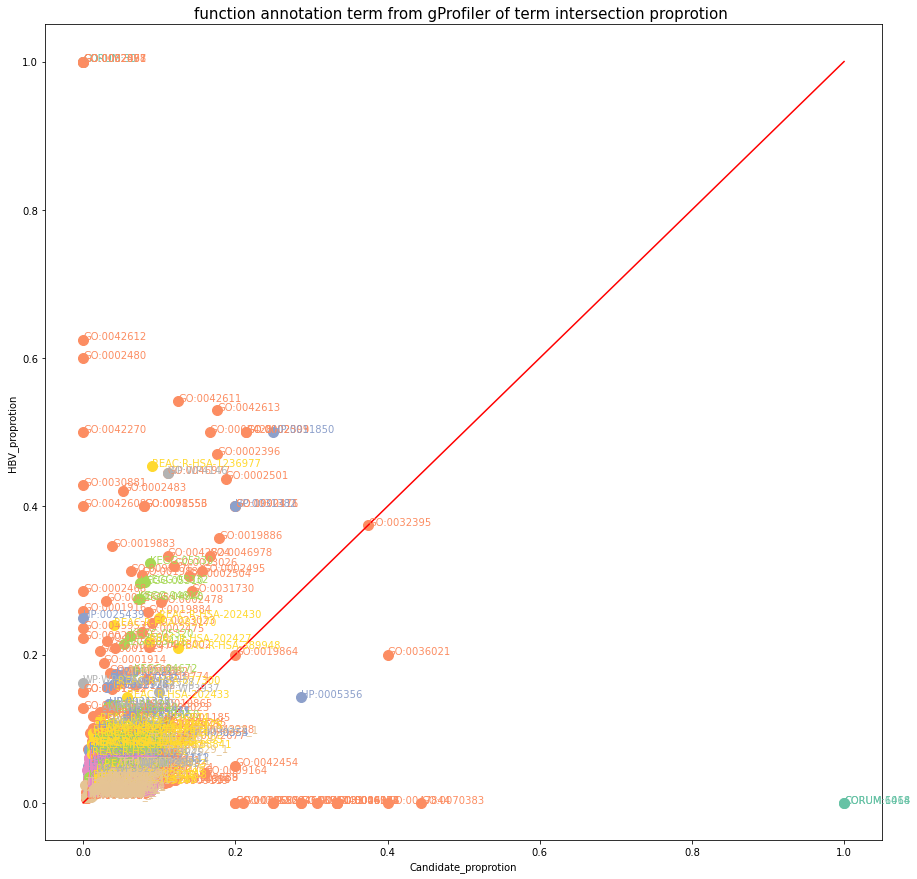

In [12]:
feature_scatter_plot(plot_df,col_x='Candidate_proprotion',col_y='HBV_proprotion',col_group='Source',col_label='GO_trem',output_path=output_path,name='gprofiler.png',title = "function annotation term from gProfiler of term intersection proprotion ")

In [42]:
subclass_g2 = pd.read_csv('BOYAULT_LIVER_CANCER_SUBCLASS_G2.csv')

### GSEA of g:profiler output

In [7]:
go_df = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/gProfiler_hsapiens_candidate_gene_intersections.csv',sep = ',')
go_idx = [bool(re.search('GO|KEGG',x)) for x in go_df['source'].values]
go_df = go_df.loc[go_idx,:]
lihc_df_candidate = lihc_df.loc[candidate_df['ID'].values,:]

In [19]:
from scipy.stats import mannwhitneyu
from random import shuffle

class gsea_of_gprofiler :

    def __init__(self,go_df,exp_df,label,pos_label):
        '''
        exp_df : data frame, expression profile row = gene,column = sample
        go_df : data frame, g:profiler output of expression matrix's gene
        label : list, label of sample class (data must be binary)
        '''
        self.go = go_df
        self.expression_matrix = exp_df
        self.sample = self.go.columns
        self.label = label
        self.pos_label = pos_label
        #self.sorted_gene_list = list(exp_df.index)

    def sort_gene_list(self,method='fc') :
        
        pos_idx = self.label == self.pos_label
        exp_pos = self.expression_matrix.loc[:,pos_idx].to_numpy()
        exp_negative = self.expression_matrix.loc[:,~pos_idx].to_numpy()
        if method == 'fc' :
            fc = np.mean(exp_pos,axis=1) / np.mean(exp_negative,axis=1)
            sort_index = sorted(range(len(fc)), key=lambda k: fc[k],reverse=True)
            self.expression_matrix = self.expression_matrix.iloc[sort_index,:]
        elif method == 'wilconox' :
            wilcox = np.zeros(self.expression_matrix.shape[0])
            for i in range(self.expression_matrix.shape[0]) :
                p = exp_pos[i,:]
                n = exp_negative[i,:]
                wilcox[i] = mannwhitneyu(p,n)[1]
                sort_index = sorted(range(len(wilcox)), key=lambda k: wilcox[k],reverse=True)
                self.expression_matrix = self.expression_matrix.iloc[sort_index,:]
        else :
            print('Method must be fold change of wilconox')
            return None
        #self.sored_gene_list = list(self.expression_matrix.index)
        
        return list(self.expression_matrix.index)

    def tsea(self,gene_list) :
        go = self.go['term_id'].values
        intersection = self.go['intersections'].values
        ko_size = self.go['term_size'].values
        enrich_score = np.zeros(len(go))
        gl = len(gene_list)

        for i in range(len(go)) :
            inter = intersection[i].split(',')
            i_n = len(inter)
            if ko_size[i] >= gl :
                loss = 1/ gl
            else :
                loss = 1/(gl - ko_size[i])
            plus = 1/ko_size[i]
            for j in range(gl) :
                if gene_list[j] in inter :
                    enrich_score[i] += plus
                    i_n -= 1
                elif i_n != 0 : 
                    enrich_score[i] -= loss
                else :
                    break

        return enrich_score
    
    def calculate_presudo_f(self,permutation = 1000) :

        sorted_gene_list = self.sort_gene_list()
        enrich_score = self.tsea(sorted_gene_list)
        presude_f = [0] * len(enrich_score)

        for i in range(permutation) :
            shuffle(sorted_gene_list)
            er = self.tsea(gene_list=sorted_gene_list)
            comparison = er > enrich_score 
            f = lambda x : 1 if x == True else 0
            r = list(map(f,comparison))
            presude_f = [presude_f[x] + r[x] for x in range(len(presude_f))]

        p_value = np.array(presude_f) / permutation
        return p_value
            
        

In [20]:
test_gsea = gsea_of_gprofiler(exp_df=lihc_df_candidate,go_df=go_df,label=sample_df['Label'].values,pos_label='Tumor')

In [21]:
pv = test_gsea.calculate_presudo_f()

In [61]:
df = pd.DataFrame({'ID' : test_gsea.go['term_id'].values,'Term_name' : test_gsea.go['term_name'].values,'Intersection' : test_gsea.go['intersection_size'].values,'p-value' : pv})

In [62]:
f = lambda x : 'Significant' if x < 0.05 else 'No significant'
df['Significant'] = list(map(f,pv))

In [63]:
from math import log10
f = lambda x : 0.0001 if x == 0 else x 
adjust_pv = list(map(f,df['p-value'].values))
log_pv = [abs(log10(x)) for x in adjust_pv]

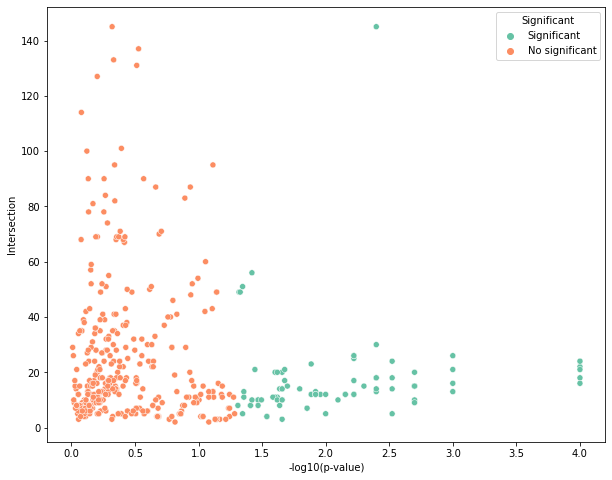

In [67]:
df['log10-p-value'] = log_pv
plt.figure(figsize=(10,8))
sns.scatterplot(data=df,x='log10-p-value',y = 'Intersection',hue = 'Significant',palette='Set2')
plt.xlabel('-log10(p-value)')
plt.savefig(output_path + 'go_pvalue_intersection.png',dpi = 300)

In [77]:
lihc_df_candidate = lihc_df_candidate.loc[gl,:]

In [78]:
lihc_df_candidate.to_csv(path + 'lihc_candidate_gene_exp_profile.txt',sep = '\t')

In [81]:
!head /home/bruce1996/data/LIHC_anomaly_detection/lihc_candidate_gene_exp_profile.txt

	A25V	A4XI	A10Z	AAVR	A7K7	A4U2	A7M5	A5NQ	A9GU	A7IJ	A5NP	A9H2	A8JO	A4NL	A7IF	AAVW	AADI	A7MF	AA46	A1ED	A4NO	A116	A75E	A75I	AADL	A2KA	A4NN	AAVU	AAW0	AAC9	AAEG	AACL	A7M7	A9CV	A8O6	A7PY	AA1C	AAU7	AACA	A8LF	A25Z	AAC8	A5UE	A9QD	AACS	A9H3	A7IH	A4NQ	A7D4	A1EC	A7IL	A10R	A5MZ	A9H5	A9H4	AB4B	A7PX	AACI	AADC	A9GY	AAD8	AADS	A5RG	A73E	A7SH	A2QQ	A12J	A8TE	AACW	A39V	A3A2	AAV7	A1EF	AACX	AADO	A459	AADD	AADA	A5SI	A69H	AAD3	A9VG	A3CJ	A3MC	A3R3	AA0V	AAV6	A3A8	A75V	A1EH	A25U	AA47	A9D2	A6GG	A10S	AADY	A3CH	A6M6	A25T	A5KG	A8O5	AAW2	A9HA	A69I	AADM	A7II	AAVX	AACD	A9HB	AAD5	AAVY	AACU	A3MA	5263	AACH	A5RF	A4NG	AAV1	A1EG	A8HS	A6C0	A3CK	A8HU	A8S7	AADW	AAAM	A119	A3KF	AADF	AAUZ	A4NB	AAEE	AADK	A9H0	A9CG	AACK	AADV	A4NJ	A3A7	A4NS	AADP	A3M9	AAD1	4072	A25S	A5DF	A73A	AAE1	A2L6	AACQ	AAV0	A9H8	A9FW	A2QR	A73F	A9FU	A73B	A3KG	A9D1	A1EE	AADG	A9D4	A1EJ	A5UC	A7XP	A26S	5264	A8TG	A3CI	AAE3	A3RK	A9GZ	A7M6	A7ME	A3A3	A25X	AACP	AAE0	AACF	A6M3	A3A4	5258	A1EA	5259	A7XO	A4NP	A114	A9FS	AACB	A66Y	A8YO	A7K8	AAVQ	AAED	A4NE	AA1D	A123	A2KC	AACC	A2KB